# Demonstration of Shallow Outlier Detection Models
1. [Introduction](#1-introduction)
2. [Point Anomaly Detection](#2-point-anomaly-detection)
    1. [Demonstration on synthetic dataset](#21-demonstration-on-synthetic-dataset)
        1. [Data generation](#211-data-generation)
        2. [Model and parameter setting](#212-model-setting)
        3. [Performances comparation](#213-performances-comparison)
    2. [Demonstration on classical dataset](#22-demonstration-on-classical-dataset)
        1. [Load data](#221-load-data)
        2. [Model and parameter setting](#222-model-setting)
        3. [Performance comparation](#223-performance-comparison)
3. [IDK for Time Series Anomaly Detection](#3-using-idk-for-time-series-anomaly-detection)
    1. [Load data](#31-load-data)
    2. [Performance](#32-performance)
4. [IDK for Graph Anomaly Detection](#4-idk-for-graph-anomaly-detection)
    1. [Load data](#41-load-data)
    2. [Performance](#42-performance)
5. [LSHiForest](#6-lshiforest)
6. [More Materials](#6-more-materials)
7. [Reference](#reference)

## 1. Introduction
This section shows the performace of shallow outlier point detection models in several synthetic and classical dataset.

## 2. Point Anomaly detection
The models covered in this demostration includes:
  1. Distance-based methods:
     1. **kNN: k Nearest Neighbors** (use the distance to the kth nearest 
     neighbor as the outlier score)
     2. **Average KNN** Outlier Detection (use the average distance to k nearest 
     neighbors as the outlier score)
  2. Density-based methods:
     1. **LOF: Local Outlier Factor**
  3. Histogram-based method:
     1. **HBOS: Histogram-based Outlier Score**
  3. Principal Componet Anaysis:
     1. **PCA: Principal Component Analysis** (use the sum of
       weighted projected distances to the eigenvector hyperplane 
       as the outlier outlier scores)
  4. Isolaiton-based methods
     1. **Isolation Forest**
     2. **Isolation NNE**
     3. **Isolation Distributional Kernel**
     4. **LSHiForest**

### 2.1. Demonstration on Synthetic Dataset

#### 2.1.1 Data generation

In [1]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
from sklearn.datasets import make_moons, make_blobs

In [2]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
]

In [3]:
# Show the statics of the data
print("Number of inliers: %i" % n_inliers)
print("Number of outliers: %i" % n_outliers)
print(
    "Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n".format(
        shape=ground_truth.shape
    )
)
print(ground_truth)

Number of inliers: 255
Number of outliers: 45
Ground truth shape is (300,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


#### 2.1.2. Model and Parameter Setting

Parameter settings
1. General paramets
    1. **contamination**, float in (0., 0.5), optional (default=0.1)
            The amount of contamination of the data set, 
            i.e. the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function.
    2. **random_state**, int, RandomState instance or None, optional (default=None)
            If int, random_state is the seed used by the random number generator;
2. ***k*NN**
    1. **n_neighbors**, int, optional (default = 5)
        Number of neighbors to use by default for k neighbors queries.
    2. **method**, str, optional (default=’largest’) {‘largest’, ‘mean’, ‘median’}
        1. **largest**: use the distance to the *k*th neighbor as the outlier score
        2. **mean**: use the average of all *k* neighbors as the outlier score
        3. **median**: use the median of the distance to *k* neighbors as the outlier score
3. **LOF**
    1. **n_neighbors**, int, optional (default=20)
        Number of neighbors to use by default for kneighbors queries. If n_neighbors is larger than the number of samples provided, all samples will be used.
4. **PCA**
    1. **n_components**, int
        Number of components to keep. if n_components is not set all components are kept.
5. **iForest**
    1. **n_estimators**, int, optional (default=100)
        The number of base estimators in the ensemble.
6. **iNNE**
    1. **n_estimators**, int, default=200
        The number of base estimators in the ensemble.
    2. **max_samples**, int or float, optional (default=”auto”)
        The number of samples to draw from X to train each base estimator.
7. **IDKD**
    1. **n_estimators**, int, default=200
        The number of base estimators in the ensemble.
    2. **max_samples**, int or float, optional (default=”auto”)
        The number of samples to draw from X to train each base estimator.
8. **LSHiForest**
    1. **number_tree**, int, default=100
        The number of tree.
    2. **number_samples**, int, default=100
        The number of random samples.
        



In [12]:
# Import all models
# !pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.inne import INNE
from src.idkd._idkd_pod import IDKD
from src.lshiforest import LSHiForest
from src.lshiforest import VSSampling
from src.lshiforest import Bagging
from src.lshiforest import LSHForest
from src.lshiforest import E2LSH, KernelLSH, AngleLSH

In [ ]:
# models setting
random_state = np.random.RandomState(42)

classifiers = {
    "KNN": KNN(contamination=outliers_fraction),
    "Average KNN": KNN(method="mean", contamination=outliers_fraction),
    "LOF": LOF(n_neighbors=35, contamination=outliers_fraction),
    "HBOS": HBOS(contamination=outliers_fraction),
    "PCA": PCA(contamination=outliers_fraction, random_state=random_state),
    "iForest": IForest(contamination=outliers_fraction, random_state=random_state),
    "iNNE": INNE(
        contamination=outliers_fraction, max_samples=16, random_state=random_state
    ),
    "ALSH": LSHForest(
        num_trees=100, sampler=VSSampling(num_samples=100), lsh_family=AngleLSH()
    ),
    "L1SH": LSHForest(
        num_trees=100, sampler=VSSampling(num_samples=100), lsh_family=E2LSH(norm=1)
    ),
    "L2SH": LSHForest(
        num_trees=100, sampler=VSSampling(num_samples=100), lsh_family=E2LSH(norm=2)
    ),
    "KLSH": LSHForest(
        num_trees=100, sampler=VSSampling(num_samples=100), lsh_family=KernelLSH()
    ),
}

#### 2.1.3. Performances Comparison

  0%|          | 0/4 [00:00<?, ?it/s]

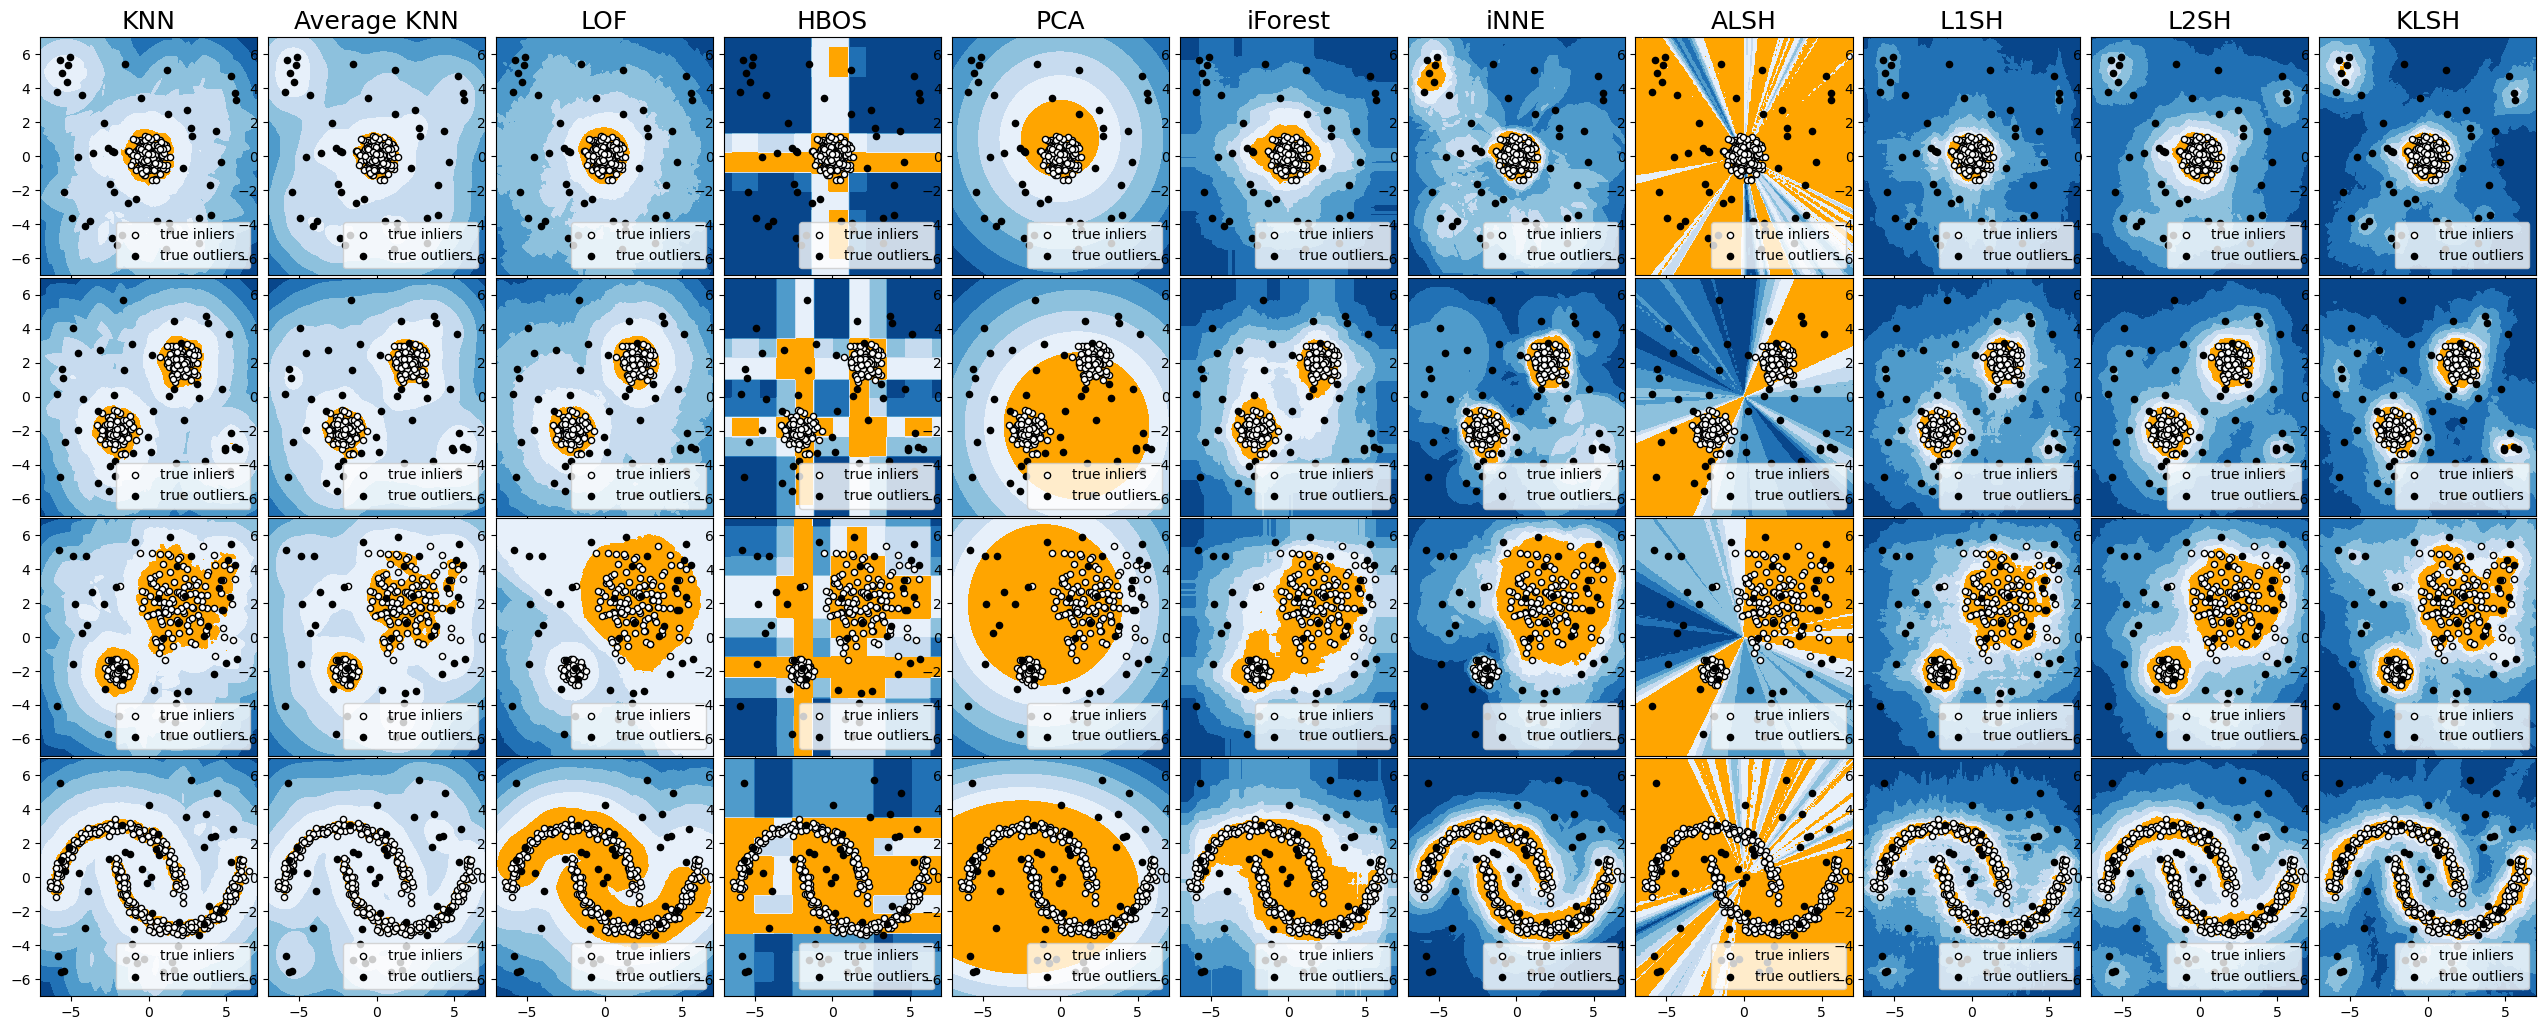

In [17]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
plt.figure(figsize=(len(classifiers) * 2 + 4, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(tqdm(datasets)):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for i_alg, (alg_name, algorithm) in enumerate(classifiers.items()):
        algorithm.fit(X)
        if alg_name == "ALSH" or alg_name == "L1SH" or alg_name == "L2SH" or alg_name == "KLSH":
            scores_pred = algorithm.decision_function(X)
        else:
            scores_pred = algorithm.decision_function(X) * -1
        #y_pred = algorithm.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)

        # plot the levels lines and the points

        if alg_name == "ALSH" or alg_name == "L1SH" or alg_name == "L2SH" or alg_name == "KLSH":
            Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = algorithm.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1

        Z = Z.reshape(xx.shape)

        subplot = plt.subplot(len(datasets), len(classifiers), plot_num)
        if i_dataset == 0:
            plt.title(alg_name, size=18)
        subplot.contourf(
            xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(
            X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k"
        )
        c = subplot.scatter(
            X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k"
        )
        subplot.axis("tight")
        subplot.legend(
            [b, c],
            ["true inliers", "true outliers"],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc="lower right",
        )
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))

        plot_num += 1

plt.show()

### 2.2. Demonstration on Classical Dataset

In [10]:
from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from time import time
import os

#### 2.2.1.  Load Data
All the following datasets are downloaded from 
Outlier Detection DataSets (ODDS): http://odds.cs.stonybrook.edu/#table1

In [13]:
mat_file_list = [
    "arrhythmia.mat",
    "cardio.mat",
    "glass.mat",
    "ionosphere.mat",
    "letter.mat",
    "lympho.mat",
    "mnist.mat",
    "musk.mat",
    "optdigits.mat",
    "pendigits.mat",
    "pima.mat",
    "satellite.mat",
    "satimage-2.mat",
    "shuttle.mat",
    "vertebral.mat",
    "vowels.mat",
    "wbc.mat",
]

#### 2.2.2. Model and Parameter Setting

In [25]:
classifiers = {
    "KNN": KNN(contamination=outliers_fraction),
    "Average KNN": KNN(method="mean", contamination=outliers_fraction),
    "LOF": LOF(n_neighbors=35, contamination=outliers_fraction),
    "HBOS": HBOS(contamination=outliers_fraction),
    "PCA": PCA(contamination=outliers_fraction, random_state=random_state),
    "iForest": IForest(contamination=outliers_fraction, random_state=random_state),
    "iNNE": INNE(
        contamination=outliers_fraction, max_samples=8, random_state=random_state
    ),
    "IDKD": IDKD(
        contamination=outliers_fraction, max_samples=16, random_state=random_state
    ),

}

classifiers_indices = {
    "KNN": 0,
    "Average KNN": 1,
    "LOF": 2,
    "HBOS": 3,
    "PCA": 4,
    "iForest": 5,
    "iNNE": 6,
    "IDKD":7
}

#### 2.2.3. Performance Comparison

In [26]:
# initialize the container for saving the results
df_columns = [
    "Data",
    "# Samples",
    "# Dimensions",
    "Outlier Perc",
    "KNN",
    "Average KNN",
    "LOF",
    "HBOS",
    "PCA",
    "IForest",
    "INNE",
    "IDKD",
]

roc_df = pd.DataFrame(columns=df_columns)
n_ite = 1
n_classifiers = 8

for j in tqdm(range(len(mat_file_list))):
    mat_file = mat_file_list[j]
    print("\n... Processing", mat_file, "...")

    data = loadmat(os.path.join("datasets/classical", mat_file))
    X = data["X"]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y = data["y"].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)

    # construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    roc_mat = np.zeros(n_classifiers)
    random_state = np.random.RandomState()
    X_norm = standardizer(X)

    for clf_name, clf in classifiers.items():
        clf.fit(X_norm)
        test_scores = clf.decision_function(X_norm)
        roc = round(roc_auc_score(y, test_scores), ndigits=4)
        roc_mat[classifiers_indices[clf_name]] = roc

    roc_list = roc_list + list(roc_mat)
    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

  0%|          | 0/17 [00:00<?, ?it/s]


... Processing arrhythmia.mat ...

... Processing cardio.mat ...

... Processing glass.mat ...

... Processing ionosphere.mat ...

... Processing letter.mat ...

... Processing lympho.mat ...

... Processing mnist.mat ...

... Processing musk.mat ...

... Processing optdigits.mat ...

... Processing pendigits.mat ...

... Processing pima.mat ...

... Processing satellite.mat ...

... Processing satimage-2.mat ...

... Processing shuttle.mat ...

... Processing vertebral.mat ...

... Processing vowels.mat ...

... Processing wbc.mat ...


In [27]:
roc_df

,Data,# Samples,# Dimensions,Outlier Perc,KNN,Average KNN,LOF,HBOS,PCA,IForest,INNE,IDKD
0,arrhythmia,452,274,14.6018,0.7684,0.7714,0.7685,0.8154,0.7748,0.786,0.7446,0.7647
0,cardio,1831,21,9.6122,0.6861,0.6141,0.5919,0.8641,0.95,0.9227,0.9133,0.9369
0,glass,214,9,4.2056,0.8325,0.8092,0.8612,0.7057,0.6027,0.6862,0.7355,0.6813
0,ionosphere,351,33,35.8974,0.9337,0.9311,0.9052,0.5647,0.7947,0.8552,0.9015,0.3726
0,letter,1600,32,6.25,0.9012,0.9234,0.8665,0.5842,0.5229,0.6245,0.6901,0.6112
0,lympho,148,18,4.0541,0.9484,0.9554,0.973,0.9953,0.9847,0.9988,0.966,0.9953
0,mnist,7603,100,9.2069,0.8368,0.8217,0.7272,0.576,0.8498,0.8151,0.8638,0.8026
0,musk,3062,166,3.1679,0.6157,0.2636,0.5848,1.0,1.0,1.0,1.0,0.9113
0,optdigits,5216,64,2.8758,0.3948,0.3374,0.4855,0.8675,0.5137,0.7114,0.6738,0.7144
0,pendigits,6870,16,2.2707,0.743,0.7212,0.4781,0.926,0.9355,0.9387,0.9129,0.8856


## 3. Using IDK for time series anomaly detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

pd.set_option("display.max_columns", None)
from src.tsod.IDK_T import IDK_T
from src.tsod.utils import get_label
from sklearn.metrics import roc_auc_score

In [4]:
# visualization
def drawIDK_T_discords(TS, idk_scores, cycle, number=3):
    sorted_index = np.argsort(idk_scores)
    plt.plot(TS, color="black")
    for index in sorted_index:
        if number <= 0:
            break
        number -= 1
        ls = range(index * cycle, (int)(index * cycle + cycle))
        ly = TS[ls]
        plt.plot(ls, ly, color="orange")
    plt.ylabel("value")

### 3.1 Load data

In [2]:
cycle = 300
anomaly_cycles = [5, 10, 20, 30]
ts_data = pd.read_csv("datasets/timeseries/noisy_sine.txt", header=None)
ts_data = np.array(ts_data).reshape((-1, 1))
scaler = preprocessing.MinMaxScaler()
X = ts_data.copy()

### 3.2 Performance

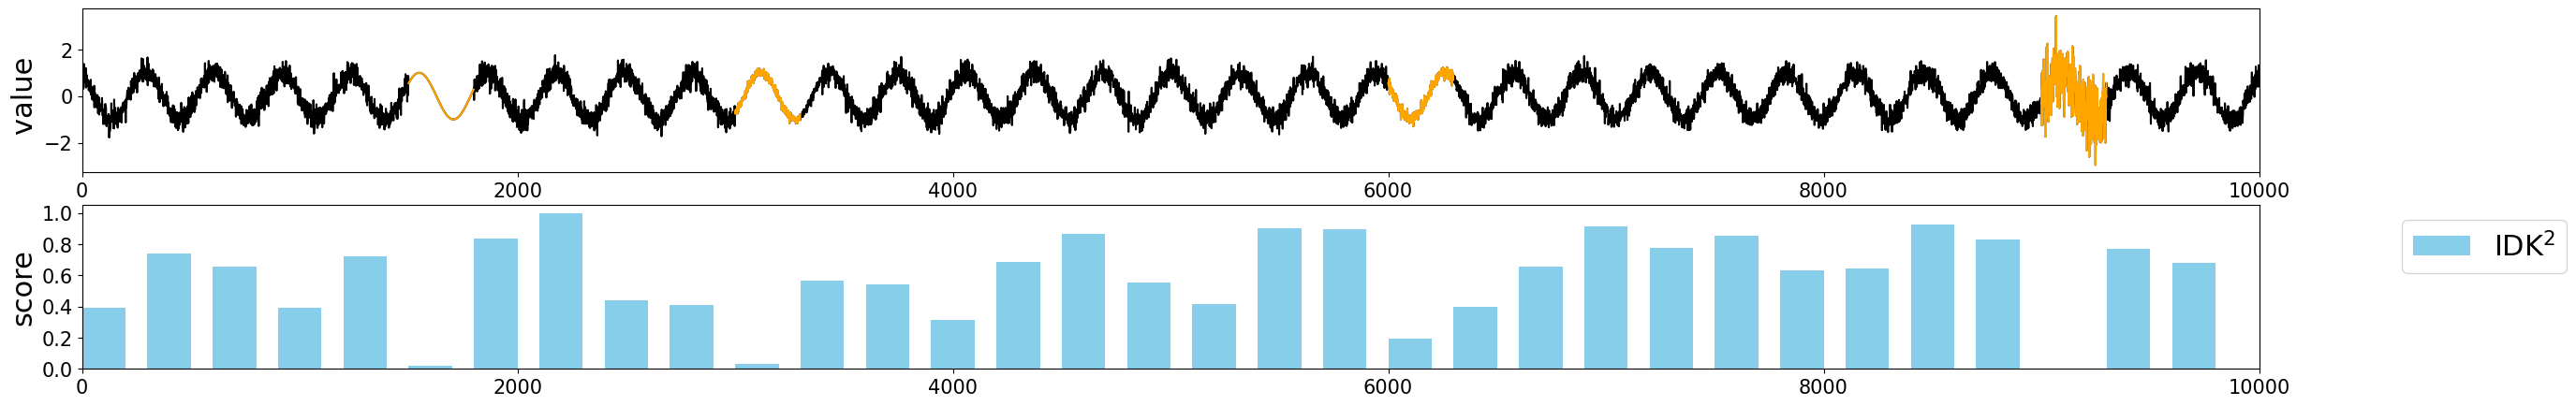

In [5]:
# set figure size
plt.rcParams["figure.figsize"] = (30.0, 5.0)
plt.subplot(2, 1, 1)

# calculate the anomaly scores of subsequences using IDK
ad_score = IDK_T(X, t=100, width=cycle, psi1=8, psi2=4)

# plot anomaly scores
drawIDK_T_discords(ts_data, ad_score, cycle, len(anomaly_cycles))
plt.xlim(0, len(ts_data))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("value ", fontsize=22)
plt.subplot(2, 1, 2)

# set font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("score", fontsize=22)

# normalize score to [0,1]
ad_score = scaler.fit_transform(np.array(ad_score).reshape(-1, 1))
barx = []
plotx = []
lo = 0
while lo + cycle - 1 < len(ts_data):
    barx.append(lo)
    lo += cycle

plt.bar(
    barx,
    ad_score.reshape(-1),
    width=cycle - 100,
    color="skyblue",
    align="edge",
    label=r"IDK$^2$",
)

for i in barx:
    plotx.append(i + cycle / 2 - 1)
plt.legend(loc="upper right", prop={"size": 22}, bbox_to_anchor=(1.148, 1))
plt.xlim(0, len(ts_data))
plt.show()

In [6]:
ground_truth = get_label(X, cycle, anomaly_cycles)
print("IDK AUC:", roc_auc_score(ground_truth, -ad_score))

IDK AUC: 1.0


## 4. IDK for graph anomaly detection

In [121]:
import numpy as np
from src.graphod.subgraph_centralization import subgraph_embeddings
from sklearn.metrics import roc_auc_score
from src.utils.iNN_IK import iNN_IK

### 4.1 Load data

In [123]:
from src.graphod.utils import load_graph
from sknetwork.visualization import svg_graph
from IPython.display import SVG

In [125]:
# load graph
data_name = "RGG_s"
attr, adj, label = load_graph("datasets/graph/{}.mat".format(data_name))
label = label.reshape(-1).astype(int)
print(
    "#Nodes:{}, #Edges:{}, #Attributes:{}, #Anomalies:{}".format(
        len(label), 2195, len(attr[0]), 20
    )
)

#Nodes:500, #Edges:2195, #Attributes:2, #Anomalies:20


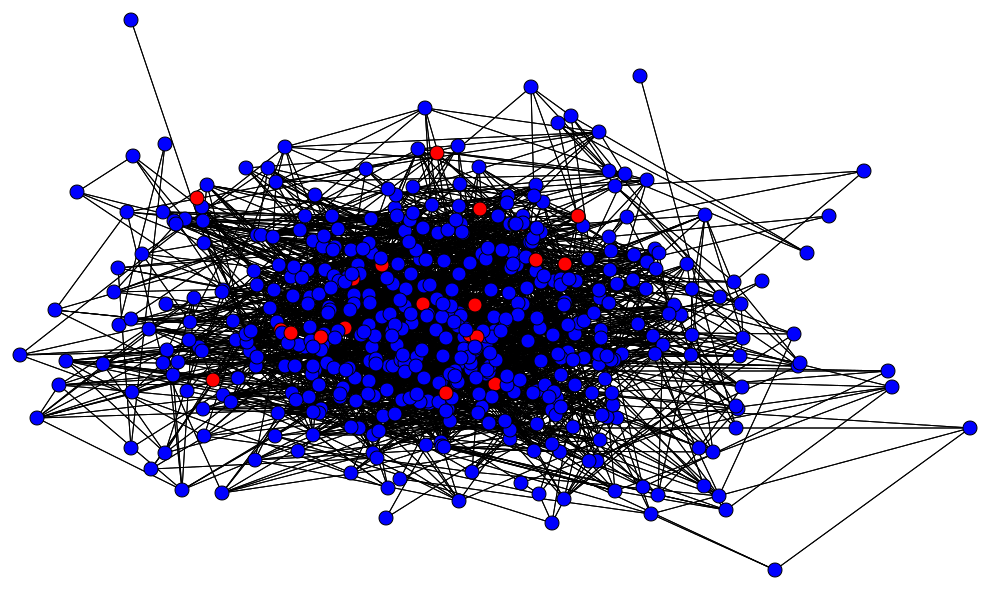

In [55]:
# Visulation
image = svg_graph(adj, labels=label, width=950, height=550)
SVG(image)

### 4.2 Performance

In [67]:
def generate_scores(scores, M, lamda):
    score_weight = [np.math.pow(lamda, i) for i in range(6)]
    en_scores = np.zeros_like(scores)
    tot = np.zeros_like(scores)
    for i in range(len(M)):
        for key, values in M[i].items():
            en_scores[key] += score_weight[values] * scores[i]
            tot[key] += score_weight[values]
    scores = np.divide(en_scores, tot)
    return np.array(scores).reshape(-1)

In [110]:
lamda = 2**-5
psi = 2
h = 2

embedding, M = subgraph_embeddings(attr, adj, h=h)
kmembeddings = iNN_IK(psi=psi, t=100).fit_transform(embedding)
mean_embedding = np.mean(kmembeddings, axis=0)
scores = kmembeddings.dot(mean_embedding.transpose())
final_scores = generate_scores(scores, M, lamda=lamda)

print(f"dataset: {data_name}, AUC: {roc_auc_score(label, -final_scores).round(3)}\n")

dataset: RGG_s, AUC: 0.908



## 5. LSHiForest

Details and more perfromance comparations about this algorithm can be found in X. Zhang et al., [**LSHiForest: A Generic Framework for Fast Tree Isolation Based Ensemble Anomaly Analysis**](https://ieeexplore.ieee.org/document/7930041), *International Conference on Data Engineering (ICDE)*, 2017.

In [11]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from src.lshiforest import VSSampling

from src.lshiforest import LSHForest
from src.lshiforest import E2LSH
from src.lshiforest import KernelLSH
from src.lshiforest import AngleLSH

iForest
AUC: 0.6251686909581646
Detected anomalies:  142
time:  0.17789053916931152
ALSH
AUC: 0.497533738191633
Detected anomalies:  160
time:  8.955960988998413
L1SH
AUC: 0.9502159244264508
Detected anomalies:  76
time:  7.519127607345581
L2SH
AUC: 0.9198549257759783
Detected anomalies:  76
time:  8.86653208732605
KLSH
AUC: 0.8873380566801621
Detected anomalies:  102
time:  68.85635113716125


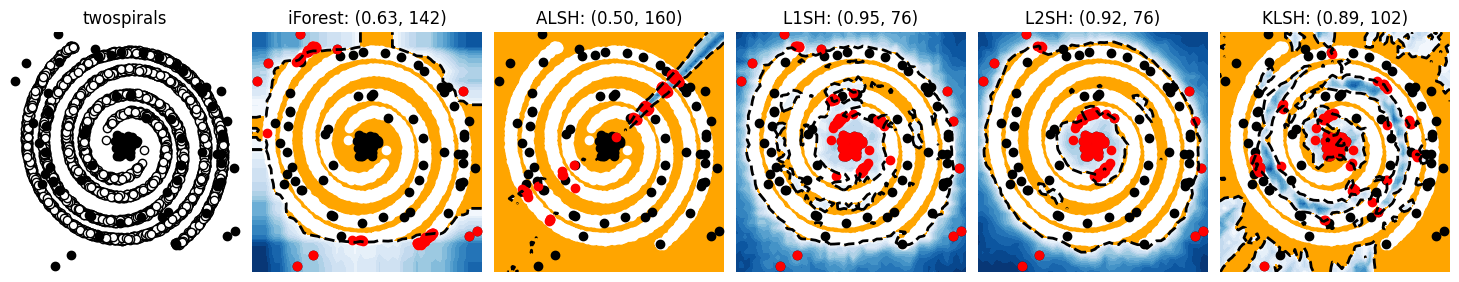

In [13]:
import warnings

warnings.filterwarnings("ignore")

plot_num = 1

rng = np.random.RandomState(42)

datasets = ["data_twospirals"]

for data_str in datasets:
    data = pd.read_csv("datasets/lshiforest/" + data_str + ".csv", header=None)
    X = data.values[:, :-1]
    ground_truth = data.values[:, -1].tolist()
    n_samples = len(ground_truth)
    outliers_fraction = 0.02

    for i in range(len(ground_truth)):
        if ground_truth[i] == 1.0:
            ground_truth[i] = False
        else:
            ground_truth[i] = True
    # print ground_truth
    mx = np.amax(X, axis=0)
    mm = np.amin(X, axis=0)

    num_ensemblers = 100
    threshold = 500

    classifiers = [
        ("iForest", IsolationForest(random_state=rng, n_estimators=num_ensemblers)),
        ("ALSH", LSHForest(num_ensemblers, VSSampling(num_ensemblers), AngleLSH(), 1)),
        (
            "L1SH",
            LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=1), 1),
        ),
        (
            "L2SH",
            LSHForest(num_ensemblers, VSSampling(num_ensemblers), E2LSH(norm=2), 1),
        ),
        (
            "KLSH",
            LSHForest(
                num_ensemblers, VSSampling(num_ensemblers), KernelLSH(3, "rbf", 0.1), 1
            ),
        ),
    ]

    # Compare given classifiers under given settings
    x_left = mm[0] - 0.05 * abs(mm[0])
    x_right = mx[0] + 0.05 * abs(mx[0])
    y_bottom = mm[1] - 0.05 * abs(mm[1])
    y_top = mx[1] + 0.02 * abs(mx[1])

    xx, yy = np.meshgrid(
        np.linspace(x_left, x_right, 50), np.linspace(y_bottom, y_top, 50)
    )
    n_inliers = int((1.0 - outliers_fraction) * n_samples)
    n_outliers = int(outliers_fraction * n_samples)

    np.random.seed(42)

    # Fit the model
    plt.figure(figsize=(15, 15 / (len(classifiers) + 1)))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
    )

    ## Plot the original twospirals
    subplot = plt.subplot(len(datasets), len(classifiers) + 1, plot_num)
    subplot.scatter(
        X[:-n_outliers, 0],
        X[:-n_outliers, 1],
        marker="o",
        c="white",
        edgecolors="black",
    )
    subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], marker="o", c="black")
    subplot.axis("tight")
    subplot.set_title("twospirals")
    subplot.set_xlim((x_left, x_right))
    subplot.set_ylim((y_bottom, y_top))
    subplot.axis("off")

    for i, (clf_name, clf) in enumerate(classifiers):
        start_time = time.time()
        print(clf_name)
        clf.fit(X)

        y_pred = clf.decision_function(X).ravel()
        auc = roc_auc_score(ground_truth, y_pred)
        print("AUC:", auc)

        threshold = stats.scoreatpercentile(y_pred, 100 * outliers_fraction)

        y_pred = y_pred > threshold

        n_errors = (y_pred != ground_truth).sum()
        print("Detected anomalies: ", n_errors)
        print("time: ", time.time() - start_time)

        # produce the anomalies detected by LSHiForest
        anomalies = []
        for i in range(len(y_pred)):
            if y_pred[i] == False:
                anomalies.append(X[i])
        anomalies = np.array(anomalies)

        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plot_num += 1
        subplot = plt.subplot(len(datasets), len(classifiers) + 1, plot_num)
        subplot.contourf(
            xx,
            yy,
            Z,
            levels=np.linspace(
                Z.min(),
                Z.max(),
                int(max([abs(x_left), abs(x_right), abs(y_bottom), abs(y_top)])),
            ),
            cmap=plt.cm.Blues_r,
        )
        subplot.contourf(
            xx,
            yy,
            Z,
            levels=np.linspace(
                Z.min(),
                threshold,
                int(max([abs(x_left), abs(x_right), abs(y_bottom), abs(y_top)])),
            ),
            cmap=plt.cm.Blues_r,
        )
        a = subplot.contour(
            xx, yy, Z, levels=[threshold], linewidths=2, linestyle="-", colors="black"
        )
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c="white")
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c="black")
        d = subplot.scatter(anomalies[:, 0], anomalies[:, 1], c="red")
        subplot.axis("tight")
        subplot.set_title("%s: (%.2f, %d)" % (clf_name, auc, n_errors))
        subplot.set_xlim((x_left, x_right))
        subplot.set_ylim((y_bottom, y_top))
        subplot.axis("off")
    # plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()

## 6. More materials

There are popular packages for time series anomaly detection:

* Matrix Profile: https://github.com/target/matrixprofile-ts
* NormA: https://helios2.mi.parisdescartes.fr/~themisp/norma/

In addition, some evaluations using deep-learning methods are available:
* https://github.com/dn3kmc/jair_anomaly_detection
* https://hpi-information-systems.github.io/timeeval-evaluation-paper/



## Reference

1. Ting et al. [**Isolation Distributional Kernel A New Tool for Point & Group Anomaly Detection**](https://ieeexplore.ieee.org/abstract/document/9573389) *IEEE Transactions on Knowledge and Data Engineering*, 2021.
2. Bandaragoda et al. [**Isolation‐based anomaly detection using nearest‐neighbor ensembles.**](https://proceedings.neurips.cc/paper_files/paper/2022/file/cf93972b116ca5268827d575f2cc226b-Paper-Datasets_and_Benchmarks.pdf) *Computational Intelligence*, 2018.
3. Han et al. [**Adbench: Anomaly detection benchmark**](https://proceedings.neurips.cc/paper_files/paper/2022/file/cf93972b116ca5268827d575f2cc226b-Paper-Datasets_and_Benchmarks.pdf) *Advances in Neural Information Processing Systems*, 2022.
4. [**PyOD** (github.com/yzhao062/pyod)](https://github.com/yzhao062/pyod)
5. [**IsolationKernel** (github.com/IsolationKernel/Codes)](https://github.com/IsolationKernel/Codes)
6. [**INNE** (github.com/xhan97/inne)](https://github.com/xhan97/inne)
7. [**IDKD** (github.com/xhan97/idkd)](https://github.com/xhan97/idkd)
